In [1]:
from pandas_datareader import data as wb
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

import threading, time, csv, numpy as np, pandas as pd
from stockstats import StockDataFrame as sdf
from matplotlib import pyplot as plt
from pylab import rcParams
from textblob import TextBlob
from selenium import webdriver

In [2]:
cur_eval = 0

eval_dict = {
    0 : 'Bad',
    1 : 'Good',
    None : 'Neutral'
}

k = 1
site = 'https://finance.yahoo.com'
tickers = ['AAPL', 'F', 'NFLX', 'MSFT', 'TSLA']

ticker_dict = {
    'AAPL' : 'Apple',
    'F' : 'Ford',
    'NFLX' : 'Netflix',
    'MSFT' : 'Microsoft',
    'TSLA' : 'Tesla'
}

print('COMPANIES')
print('0 : AAPL (Apple)')
print('1 : F (Ford)')
print('2 : NFLX (Netflix)')
print('3 : MSFT (Microsoft)')
print('4 : TSLA (Tesla)\n')
val = int(float(input('This function gets the most recent sentiment on a specific company. Enter an integer: ')))
cur_ticker = tickers[val]
name = ticker_dict.get(cur_ticker)
print('You chose:\n{0} : {1} ({2})\n'.format(str(val), cur_ticker, name))
driver = webdriver.Firefox(executable_path='./geckodriver')
driver.get(site)

try:
    driver.find_element_by_xpath('//button[@name="agree"]').click()
except:
    pass

for scroll in range(20):
    driver.execute_script('window.scrollBy(0, 2000)')
    time.sleep(2)

link_elems = driver.find_elements_by_xpath('//ul/li/div/div/div/h3/a')

for elem in link_elems:
    if 'finance.yahoo' in elem.get_attribute('href'):
        if name.upper() in elem.text.upper():
            print('Article name: ' + elem.text)
            driver2 = webdriver.Firefox(executable_path='./geckodriver')
            driver2.get(elem.get_attribute('href'))

            try:
                driver2.find_element_by_xpath('//button[@name="agree"]').click()
            except:
                pass

            print('Yahoo Finance {0} article #{1} opened.'.format(name, k))
            article_text = driver2.find_elements_by_xpath('//article/div/p')
            file = open('current_text.txt', 'w')

            for p in article_text:
                if p.get_attribute('content')[:7] == '<a href':
                    break
                file.write(p.text+' ')

            file.close()
            file = open('current_text.txt', 'r')

            polarity = TextBlob(file.read()).sentiment.polarity

            if polarity < 0:
                eval_int = 0
                cur_eval -= 1
            elif polarity > 0:
                eval_int = 1
                cur_eval += 1
            else:
                eval_int = None

            print('{0} article #{1} sentiment: {2}.\n'.format(name, str(k), eval_dict.get(eval_int)))
            k += 1

            file.close()
            driver2.close()

driver.close()
file = open('current_text.txt', 'w')
file.close()
            
if cur_eval > 0:
    overall_eval_int = 1
elif cur_eval < 0:
    overall_eval_int = 0
else:
    overall_eval_int = None

print('Current {0} sentiment: {1}.'.format(name, eval_dict.get(overall_eval_int)))

COMPANIES
0 : AAPL (Apple)
1 : F (Ford)
2 : NFLX (Netflix)
3 : MSFT (Microsoft)
4 : TSLA (Tesla)

This function gets the most recent sentiment on a specific company. Enter an integer: 0
You chose:
0 : AAPL (Apple)

Article name: Apple Upgraded Ahead of Earnings
Yahoo Finance Apple article #1 opened.
Apple article #1 sentiment: Good.

Current Apple sentiment: Good.


In [3]:
stock_data = wb.DataReader(cur_ticker, data_source='yahoo', start='1900-1-1')

In [4]:
indicators = sdf.retype(stock_data)
indicators['boll']
indicators['boll_ub']
indicators['boll_lb']
indicators['macd']
print('')

<function matplotlib.pyplot.show(*args, **kw)>

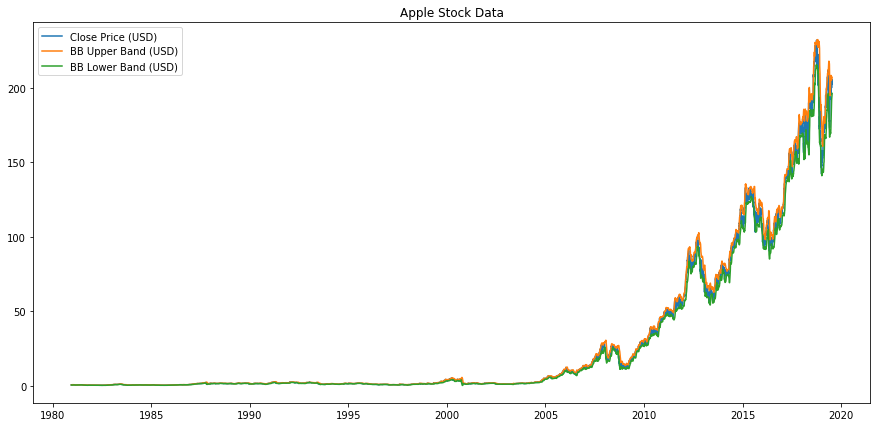

In [5]:
rcParams['figure.figsize'] = 15, 7
plt.plot(stock_data['close'], label='Close Price (USD)')
plt.plot(stock_data['boll_ub'], label='BB Upper Band (USD)')
plt.plot(stock_data['boll_lb'], label='BB Lower Band (USD)')
plt.title('{0} Stock Data'.format(name))
plt.legend()
plt.show()

-------------------------------------

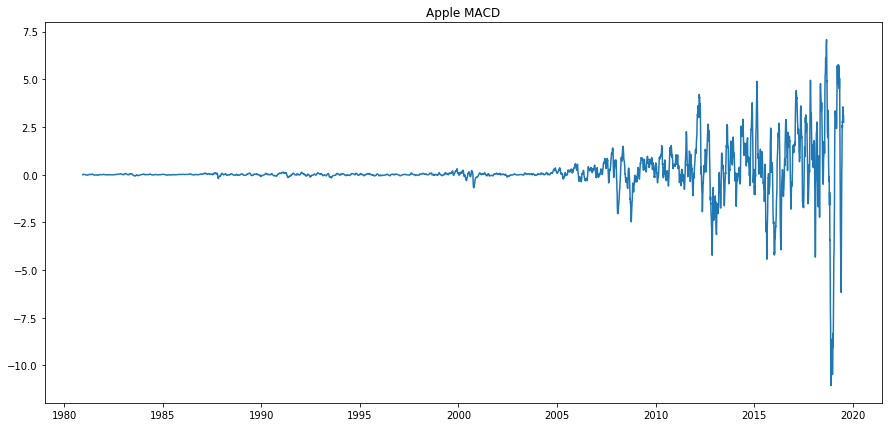

In [6]:
rcParams['figure.figsize'] = 15, 7
plt.plot(stock_data['macd'], label='MACD')
plt.title(name+' MACD')
plt.show()